In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
import numpy as np
import seaborn as sns
import os
import fastparquet
import warnings
import geopy
from geopy.point import Point
import time
from pandas.core.common import SettingWithCopyWarning
import plotly.graph_objects as go
import plotly.express as px
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

#df = pd.read_parquet('Downloads/airbnb_parquets')
#df.to_csv('csv_printout.csv')

In [95]:
def append_fig_to_html(list_of_figs):
    for fig in list_of_figs:
        with open("reports/report_draft.html",'a') as f:
            f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))

# write this later
"""
def overwrite_html(list_of_figs):
    
    with open("reports/report_draft.html",'w') as f:
    f.write(listing_fig.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(price_fig.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(price_v_numlist_fig.to_html(full_html=False, include_plotlyjs='cdn'))
"""

property_tax_map = {
    'AL' : 0.0037,
    'AK' : 0.0098,
    'AZ' : 0.0060,
    'AK' : 0.0061,
    'CA' : 0.0070,
    'CO' : 0.0052,
    'CT' : 0.0173,
    'DE' : 0.0059,
    'FL' : 0.0086,
    'GA' : 0.0087,
    'HI' : 0.0031,
    'ID' : 0.0065,
    'IL' : 0.0197,
    'IN' : 0.0081,
    'IA' : 0.0143,
    'KS' : 0.0128,
    'KY' : 0.0078,
    'LA' : 0.0051,
    'ME' : 0.0120,
    'MD' : 0.0101,
    'MA' : 0.0108,
    'MI' : 0.0131,
    'MN' : 0.0105,
    'MS' : 0.0063,
    'MO' : 0.0096,
    'MT' : 0.0074,
    'NE' : 0.0154,
    'NV' : 0.0056,
    'NH' : 0.0189,
    'NJ' : 0.0213,
    'NM' : 0.0059,
    'NY' : 0.0130,
    'NC' : 0.0078,
    'ND' : 0.0088,
    'OH' : 0.0152,
    'OK' : 0.0083,
    'OR' : 0.0091,
    'PA' : 0.0143,
    'RI' : 0.0137,
    'SC' : 0.0053,
    'SD' : 0.0114,
    'TN' : 0.0063,
    'TX' : 0.0160,
    'UT' : 0.0056,
    'VT' : 0.0176,
    'VA' : 0.0084,
    'WA' : 0.0084,
    'WV' : 0.0053,
    'WI' : 0.0153,
    'WY' : 0.0051,
    'DC' : 0.0058
}

def calculate_monthly_maintenance(home_value):
    monthly_maintenance = home_value/100/12
    return monthly_maintenance

def calculate_monthly_taxes(home_value, state_id, property_tax_map=property_tax_map):
    tax_rate = property_tax_map.get(state_id)
    monthly_tax = home_value*tax_rate/12
    return monthly_tax

def calculate_mortgage(home_value, interest_rate, num_years, down_payment_pct=0):
    if home_value is None:
        return None
    
    per_payment_interest = 0
    loan_value = 0


    if down_payment_pct >= 1:
        down_payment = down_payment_pct/100 * home_value
        loan_value = home_value - down_payment
    else:
        down_payment = down_payment_pct * home_value
        loan_value = home_value - down_payment
    
    if loan_value/home_value < 0.80: 
        # insert pmi calc here
        pmi = 0.01  # using near average value here
        pmi_cost = 0.0007*home_value    # shot in the dark after interpolating nerdwallet calculator
        if interest_rate >= 1:
            per_payment_interest = interest_rate/100/12
        else:
            per_payment_interest = interest_rate/12
        num_months = num_years*12
        mortgage = loan_value*(per_payment_interest*(1+per_payment_interest)**num_months)/((1+per_payment_interest)**num_months-1) + pmi_cost

        mortgage = np.round(mortgage, 2)
        return mortgage
    else:
        if interest_rate >= 1:
            per_payment_interest = interest_rate/100/12
        else:
            per_payment_interest = interest_rate/12
        num_months = num_years*12
        mortgage = loan_value*(per_payment_interest*(1+per_payment_interest)**num_months)/((1+per_payment_interest)**num_months-1)

        mortgage = np.round(mortgage, 2)
        return mortgage

def calculate_roi(airbnb_daily_price, occupancy_rate, monthly_mortgage, monthly_maintenence=0, monthly_taxes=0):
    gross_rev = airbnb_daily_price * occupancy_rate * 365/12
    net_rev = gross_rev - monthly_maintenence - monthly_taxes
    profit = net_rev - monthly_mortgage
    roi = profit/monthly_mortgage
    roi = roi
    return roi

def set_location_desc(lat,long):
    from geopy.geocoders import Nominatim
    geolocator = Nominatim(user_agent="geoapiExercises")
    lat = str(lat)
    long = str(long)
    location = geolocator.reverse(lat+","+long)
    address = location.raw['address']
    city = address.get('city', '')
    state = address.get('state', '')
    country = address.get('country')
    country_code = address.get('country_code')
    zipcode = address.get('postcode', '')
    return city, state, country, country_code, zipcode

def set_city(lat, long):
    from geopy.geocoders import Nominatim
    geolocator = Nominatim(user_agent="geoapiExercises")
    #start_time = time.time()
    lat = str(lat)
    #print("---Latitude casted to string at %s seconds ---" % (time.time() - start_time))

    long = str(long)
    #print("---Longitude casted at %s seconds ---" % (time.time() - start_time))

    location = geolocator.reverse(lat+","+long)
    #print("---Get location json from geopy at %s seconds ---" % (time.time() - start_time))

    address = location.raw['address']
    #print("---Get address json at %s seconds ---" % (time.time() - start_time))

    city = address.get('city', '')
    #print("---Get city value at %s seconds ---" % (time.time() - start_time))
    return city

def set_state(lat, long):
    from geopy.geocoders import Nominatim
    geolocator = Nominatim(user_agent="geoapiExercises")
    lat = str(lat)
    long = str(long)
    location = geolocator.reverse(Point(lat,long))
    address = location.raw['address']
    state = address.get('state', '')
    return state

def set_country(lat, long):
    from geopy.geocoders import Nominatim
    geolocator = Nominatim(user_agent="geoapiExercises")
    lat = str(lat)
    long = str(long)
    location = geolocator.reverse(Point(lat,long))
    address = location.raw['address']
    country = address.get('country')
    return country

def set_country_code(lat, long):
    from geopy.geocoders import Nominatim
    geolocator = Nominatim(user_agent="geoapiExercises")
    lat = str(lat)
    long = str(long)
    location = geolocator.reverse(lat+","+long)
    address = location.raw['address']
    country_code = address.get('country_code')
    return country_code

def set_zipcode(lat, long):
    from geopy.geocoders import Nominatim
    geolocator = Nominatim(user_agent="geoapiExercises")
    lat = str(lat)
    long = str(long)
    location = geolocator.reverse(Point(lat,long))
    address = location.raw['address']
    zipcode = address.get('postcode', '')
    return zipcode

def set_interpolated_state(top_lat,bottom_lat,left_long,right_long):
    lat = (top_lat+bottom_lat)/2
    long = (left_long+right_long)/2
    state = set_state(lat, long)
    return state


def set_avg_home_val(home_values, city, state, num_beds):
    if num_beds <= 5:
        desired_row = home_values[(home_values['RegionName'] == city) & (home_values['State'] == state) & (home_values['num_beds'] == num_beds)]
        avg_value = desired_row['2022-04-30']
        if len(avg_value) == 0:
            return None
        else:
            return avg_value.iloc[0]
    else:
        desired_row = home_values[(home_values['RegionName'] == city) & (home_values['State'] == state) & (home_values['num_beds'] == 5)]
        avg_value = desired_row['2022-04-30']
        if len(avg_value) == 0:
            return None
        else:
            return avg_value.iloc[0]*num_beds/5  # <-- improve this with linear regression later on

def list_options_for_dash(df_series):
    options = []
    value = 0
    for i in df_series:
        if value == 0:
            value = i
        town = {'label':i, 'value':i}
        dict_copy = town.copy()
        options.append(dict_copy)
    return options, value


In [176]:
listing_data_static['state_id'].head()

0    SC
1    SC
2    SC
3    SC
4    SC
Name: state_id, dtype: object

In [47]:
# Load in listing data
nc_dir = 'C:/Users/mattg/Desktop/Hobbies/airbnb_reports/bucket_data/listings/north_carolina'
first_file = ''
for file in os.listdir(nc_dir):
    first_file = os.path.join(nc_dir,file)
    break
listing_data = pd.read_parquet(first_file)
print(listing_data.shape)
for file in os.listdir(nc_dir):
    next_file = os.path.join(nc_dir,file)
    if next_file != first_file:
        next_listing = pd.read_parquet(next_file)
        listing_data = listing_data.append(next_listing)
print(listing_data.shape)

ne_dir = 'C:/Users/mattg/Desktop/Hobbies/airbnb_reports/bucket_data/listings/vt_nh'
for file in os.listdir(ne_dir):
    next_file = os.path.join(ne_dir,file)
    next_listing = pd.read_parquet(next_file)
    listing_data = listing_data.append(next_listing)
print(listing_data.shape)

miami_dir = 'C:/Users/mattg/Desktop/Hobbies/airbnb_reports/bucket_data/listings/miami'
for file in os.listdir(miami_dir):
    next_file = os.path.join(miami_dir,file)
    next_listing = pd.read_parquet(next_file)
    listing_data = listing_data.append(next_listing)
print(listing_data.shape)

# Load in occupancy data
occ_data = pd.read_parquet('C:/Users/mattg/Desktop/Hobbies/airbnb_reports/bucket_data/occupancy')

# Load in price data
price_data = pd.read_parquet('C:/Users/mattg/Desktop/Hobbies/airbnb_reports/bucket_data/prices')

(1, 25)
(2468, 25)
(4224, 25)
(5535, 25)


In [28]:
# Load in occupancy data
occ_data = pd.read_parquet('C:/Users/mattg/Desktop/Hobbies/airbnb_reports/bucket_data/occupancy')

# Load in price data
price_data = pd.read_parquet('C:/Users/mattg/Desktop/Hobbies/airbnb_reports/bucket_data/prices')

In [4]:
top_lats = listing_data.top_lat.unique()
bottom_lats = listing_data.bottom_lat.unique()
left_longs = listing_data.left_long.unique()
right_longs = listing_data.right_long.unique()
partitions = {'top_lat': top_lats, 'bottom_lat': bottom_lats, 'left_long': left_longs, 'right_long': right_longs}
partition_df = pd.DataFrame(data=partitions)

ValueError: All arrays must be of the same length

In [5]:
# Clean up listing_data
conditions = [
    listing_data['baths'].str.contains('shared', na=False),
    listing_data['baths'].str.contains('Shared', na=False)
]

values = ['Shared', 'Shared']

listing_data['baths_type'] = np.select(conditions, values, default='Private')

conditions_loc = [
    listing_data['top_lat'] > 35.5,
    listing_data['top_lat'] < 28
]

values_loc = ['New England', 'Miami']

listing_data['Region'] = np.select(conditions_loc, values_loc, default='Carolinas')


conditions_halfbath = [
    listing_data['baths'].str.contains('Half-bath', na=False),
    listing_data['baths'].str.contains('Shared half-bath', na=False),
    listing_data['baths'].str.contains('Private half-bath', na=False)
]

values_halfbath = [0.5,0.5,0.5]

listing_data['baths'] = np.select(conditions_halfbath, values_halfbath, default=listing_data['baths'])

listing_data['baths_no'] = listing_data['baths'].str.split(' ').str[0]
listing_data['beds_no'] = listing_data['beds'].str.split(' ').str[0]
listing_data['guest_no'] = listing_data['title'].str.split(' ').str[0]
listing_data['guest_no'] = listing_data['guest_no'].astype('float')
listing_data['id'] = listing_data['id'].astype('float64')
listing_data['id'] = listing_data['id'].astype('str')
listing_data['town'] = listing_data['town'].str.lower()
listing_data = listing_data[listing_data.lat.isna() == False]
#listing_data['city_geopy'] = listing_data.apply(lambda row: set_city(row['lat'], row['lng']), axis=1)
#listing_data['state_geopy'] = listing_data.apply(lambda row: set_state(row['lat'], row['lng']), axis=1)
#listing_data['country_geopy'] = listing_data.apply(lambda row: set_country(row['lat'], row['lng']), axis=1)
#listing_data['country_code_geopy'] = listing_data.apply(lambda row: set_country_code(row['lat'], row['lng']), axis=1)
#listing_data['zipcode_geopy'] = listing_data.apply(lambda row: set_zipcode(row['lat'], row['lng']), axis=1)

# Clean up occ_data
#occ_data['id'] = occ_data['id'].astype('int')
occ_data['id'] = occ_data['id'].astype('str')

# Clean up price_data
#price_data['id'] = price_data['id'].astype('int')
price_data['id'] = price_data['id'].astype('str')

In [81]:
occ_data_date = occ_data.groupby(['date'])['available'].apply(lambda row: np.sum(row)/len(row)).reset_index()

occupancy_rate_fig = px.line(occ_data_date,
        x="date",
        y="available",
        title="Occupancy Rate by Date"
    )

filename = "newsletter_features/occupancy_rate_line_fig.png"
occupancy_rate_fig.write_image(filename, engine='kaleido')
occupancy_rate_fig.show()

In [68]:
price_data_date = price_data.groupby(['check_in'])['cleaning_fee','service_fee','total_price'].apply(lambda row: np.sum(row)/len(row)).reset_index()

In [79]:
# Create traces
price_data_line_fig = go.Figure()
price_data_line_fig.add_trace(go.Scatter(x=price_data_date['check_in'], y=price_data_date['cleaning_fee'],
                    mode='lines',
                    name='Cleaning Fee'))
price_data_line_fig.add_trace(go.Scatter(x=price_data_date['check_in'], y=price_data_date['service_fee'],
                    mode='lines',
                    name='Service Fee'))
price_data_line_fig.add_trace(go.Scatter(x=price_data_date['check_in'], y=price_data_date['total_price'],
                    mode='lines', 
                    name='Total Price'))
price_data_line_fig.update_layout(title_text="Pricing Data by Date", xaxis_title='Date', yaxis_title='Price ($)')
filename = "newsletter_features/price_data_line_fig.png"
price_data_line_fig.write_image(filename, engine='kaleido', width=2000, height=500)
price_data_line_fig.show()

In [74]:
price_data_bar_fig = go.Figure(data=[
    go.Bar(name='Cleaning Fee', x=price_data_date['check_in'], y=price_data_date['cleaning_fee']),
    go.Bar(name='Service Fee', x=price_data_date['check_in'], y=price_data_date['service_fee']),
    #go.Bar(name='Total Price', x=price_data_date['check_in'], y=price_data_date['total_price']),
],
    layout={
        'xaxis': {'title': 'Date'},
        'yaxis': {'title': 'Price ($)'},
    }
)

# Change the bar mode
price_data_bar_fig.update_layout(title_text='Pricing Data by Date', barmode='stack')
filename = "newsletter_features/price_data_bar_fig.png"
price_data_bar_fig.write_image(filename, engine='kaleido')
price_data_bar_fig.show()

In [107]:
start_time = time.time()
listing_data['state'] = listing_data.apply(lambda row: set_state(row['lat'], row['lng']), axis=1)
end_time = time.time()
print('Time to run was ' + str(start_time-end_time))

Time to run was -1388.3272874355316


In [109]:
listing_data.to_csv('listings_w_states.csv')

In [25]:
listing_data_static = pd.read_csv('listings_w_states.csv')
city_data = pd.read_csv('resource_data/uscities.csv')
state_convert = city_data[['state_name','state_id']]
state_convert = state_convert.drop_duplicates()
listing_data_static = listing_data_static.merge(state_convert, left_on='state', right_on='state_name')
#home_value = pd.read_csv('resource_data/home_value_zillow.csv')
home_value_1bed = pd.read_csv('resource_data/zillow_city_onebed.csv')
home_value_2bed = pd.read_csv('resource_data/zillow_city_twobed.csv')
home_value_3bed = pd.read_csv('resource_data/zillow_city_threebed.csv')
home_value_4bed = pd.read_csv('resource_data/zillow_city_fourbed.csv')
home_value_5plusbed = pd.read_csv('resource_data/zillow_city_fiveplusbed.csv')

home_value_1bed['RegionName'] = home_value_1bed['RegionName'].str.lower()
home_value_1bed_reduced = home_value_1bed[['RegionName','CountyName', 'Metro', 'StateName','State', '2022-04-30']]
home_value_1bed_reduced['num_beds'] = 1

home_value_2bed['RegionName'] = home_value_2bed['RegionName'].str.lower()
home_value_2bed_reduced = home_value_2bed[['RegionName','CountyName', 'Metro', 'StateName','State', '2022-04-30']]
home_value_2bed_reduced['num_beds'] = 2

home_value_3bed['RegionName'] = home_value_3bed['RegionName'].str.lower()
home_value_3bed_reduced = home_value_3bed[['RegionName','CountyName', 'Metro', 'StateName','State', '2022-04-30']]
home_value_3bed_reduced['num_beds'] = 3

home_value_4bed['RegionName'] = home_value_4bed['RegionName'].str.lower()
home_value_4bed_reduced = home_value_4bed[['RegionName','CountyName', 'Metro', 'StateName','State', '2022-04-30']]
home_value_4bed_reduced['num_beds'] = 4

home_value_5plusbed['RegionName'] = home_value_5plusbed['RegionName'].str.lower()
home_value_5plusbed_reduced = home_value_5plusbed[['RegionName','CountyName', 'Metro', 'StateName','State', '2022-04-30']]
home_value_5plusbed_reduced['num_beds'] = 5

home_values = home_value_1bed_reduced.append(home_value_2bed_reduced)
home_values = home_values.append(home_value_3bed_reduced)
home_values = home_values.append(home_value_4bed_reduced)
home_values = home_values.append(home_value_5plusbed_reduced)

home_values_lookup = home_values[['RegionName','State', 'num_beds', '2022-04-30']]
home_values_lookup = home_values_lookup.drop_duplicates()
#listing_data_static = listing_data_static.merge(home_values, how='inner', left_on = ['state_id','beds_no'], right_on=['State','num_beds'])  # <-- Join to give avg house value for bedroom size
#home_values = [['RegionName', 'CountyName', 'Metro', 'State', 'state_name', '2022-04-30', 'num_beds']] 

In [26]:
listing_data_static['avg_home_value'] = listing_data_static.apply(lambda row: set_avg_home_val(home_values, row['town'], row['state_id'], row['beds_no']),axis=1)
#lambda row: set_avg_home_val(home_values, listing_data_static['town'], listing_data_static['state_id'], listing_data_static['beds_no'], axis=1)

In [228]:
value = set_avg_home_val(home_values, 'clinton', 'NC', 2)


2122    87152.0
Name: 2022-04-30, dtype: float64


In [31]:
listing_data = listing_data_static
listing_data['id'] = listing_data['id'].astype('str')

occ_rate = occ_data.groupby('id')['available'].apply(lambda row: np.sum(row)/len(row))
occ_rate['id'] = occ_rate['id'].astype('str')
combined_data = listing_data.merge(occ_rate, on = 'id')
combined_data.rename(columns = {'available':'occupancy_rate'}, inplace = True)

cleaning_fee = price_data.groupby(['id'])['cleaning_fee'].median().reset_index()
cleaning_fee.rename(columns = {'cleaning_fee':'median_cleaning_fee'}, inplace = True)
service_fee = price_data.groupby(['id'])['service_fee'].median().reset_index()
service_fee.rename(columns = {'service_fee':'median_service_fee'}, inplace = True)
combined_data = combined_data.merge(cleaning_fee, on='id')
combined_data = combined_data.merge(service_fee, on='id')
combined_data['median_total_price'] = combined_data['price'] + combined_data['median_cleaning_fee'] + combined_data['median_service_fee']

#home_value['RegionName'] = home_value['RegionName'].str.lower()
#home_value_reduced = home_value[['RegionName','CountyName', 'Metro', 'State', '2022-04-30']]
#combined_data = combined_data.merge(home_value, left_on='town', right_on='RegionName')


KeyError: 'id'

In [33]:
combined_data = pd.read_csv('post_home_cals_and_merges.csv')

# Adding avg mortgage and median ROI
combined_data['avg_30_yr_mort'] = combined_data.apply(lambda row: calculate_mortgage(row['avg_home_value'], 5, 30), axis=1)
combined_data['monthly_maintenance'] = combined_data.apply(lambda row: calculate_monthly_maintenance(row['avg_home_value']), axis=1)
combined_data['monthly_tax'] = combined_data.apply(lambda row: calculate_monthly_taxes(row['avg_home_value'], row['state_id']), axis=1)
combined_data['median_ROI'] = combined_data.apply(lambda row: calculate_roi(row['median_total_price'], row['occupancy_rate'], row['avg_30_yr_mort'], row['monthly_maintenance'], row['monthly_tax']), axis=1)

In [34]:
combined_data.shape

(275, 44)

In [ ]:
# Table for region and property type
region_proptype_roi = combined_data.groupby(['Region','property_type'])['median_ROI'].median().reset_index()

In [42]:
len(listing_data.id.unique())

2420

In [5]:
combined_data = pd.read_csv('post_mort_and_roi_calcs.csv')

In [6]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

roi_subplots = make_subplots(rows=3, cols=2)

combined_data_vt = combined_data[(combined_data['state_id'] == 'VT')]
combined_data_nh = combined_data[(combined_data['state_id'] == 'NH')]
combined_data_nc = combined_data[(combined_data['state_id'] == 'NC')]
combined_data_sc = combined_data[(combined_data['state_id'] == 'SC')]
combined_data_fl = combined_data[(combined_data['state_id'] == 'FL')]
combined_data_me = combined_data[(combined_data['state_id'] == 'ME')]

combined_data_vt_mean_roi = combined_data_vt.groupby(['town'])['median_ROI'].mean().reset_index()
combined_data_nh_mean_roi = combined_data_nh.groupby(['town'])['median_ROI'].mean().reset_index()
combined_data_nc_mean_roi = combined_data_nc.groupby(['town'])['median_ROI'].mean().reset_index()
combined_data_sc_mean_roi = combined_data_sc.groupby(['town'])['median_ROI'].mean().reset_index()
combined_data_fl_mean_roi = combined_data_fl.groupby(['town'])['median_ROI'].mean().reset_index()
combined_data_me_mean_roi = combined_data_me.groupby(['town'])['median_ROI'].mean().reset_index()


roi_subplots.append_trace(
    go.Bar(x=combined_data_vt_mean_roi['town'],
    y=combined_data_vt_mean_roi['median_ROI'], name="VT"
), row=1, col=1)

roi_subplots.append_trace(go.Bar(
    x=combined_data_nh_mean_roi['town'],
    y=combined_data_nh_mean_roi['median_ROI'], name="NH"
), row=1, col=2)

roi_subplots.append_trace(go.Bar(
    x=combined_data_nc_mean_roi['town'],
    y=combined_data_nc_mean_roi['median_ROI'], name="NC"
), row=2, col=1)

roi_subplots.append_trace(go.Bar(
    x=combined_data_sc_mean_roi['town'],
    y=combined_data_sc_mean_roi['median_ROI'], name="SC"
), row=2, col=2)

roi_subplots.append_trace(go.Bar(
    x=combined_data_fl_mean_roi['town'],
    y=combined_data_fl_mean_roi['median_ROI'], name="FL"
), row=3, col=1)

roi_subplots.append_trace(go.Bar(
    x=combined_data_me_mean_roi['town'],
    y=combined_data_me_mean_roi['median_ROI'], name="ME"
), row=3, col=2)


roi_subplots.update_layout(height = 1100, title_text="Mean ROI for Cities in each State", barmode='group')
#filename = "newsletter_features/mean_roi_for_cities_by_state.png"
#roi_subplots.write_image(filename, engine='kaleido')

roi_subplots.show()

In [36]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

roi_guest_subplots = make_subplots(rows=3, cols=2)

combined_data_vt = combined_data[(combined_data['state_id'] == 'VT')]
combined_data_nh = combined_data[(combined_data['state_id'] == 'NH')]
combined_data_nc = combined_data[(combined_data['state_id'] == 'NC')]
combined_data_sc = combined_data[(combined_data['state_id'] == 'SC')]
combined_data_fl = combined_data[(combined_data['state_id'] == 'FL')]
combined_data_me = combined_data[(combined_data['state_id'] == 'ME')]

combined_data_vt_mean_roi_guest = combined_data_vt.groupby(['guest_no'])['median_ROI'].mean().reset_index()
combined_data_nh_mean_roi_guest = combined_data_nh.groupby(['guest_no'])['median_ROI'].mean().reset_index()
combined_data_nc_mean_roi_guest = combined_data_nc.groupby(['guest_no'])['median_ROI'].mean().reset_index()
combined_data_sc_mean_roi_guest = combined_data_sc.groupby(['guest_no'])['median_ROI'].mean().reset_index()
combined_data_fl_mean_roi_guest = combined_data_fl.groupby(['guest_no'])['median_ROI'].mean().reset_index()
combined_data_me_mean_roi_guest = combined_data_me.groupby(['guest_no'])['median_ROI'].mean().reset_index()


roi_guest_subplots.append_trace(
    go.Bar(x=combined_data_vt_mean_roi_guest['guest_no'],
    y=combined_data_vt_mean_roi_guest['median_ROI'], name="VT"
), row=1, col=1)

roi_guest_subplots.append_trace(go.Bar(
    x=combined_data_nh_mean_roi_guest['guest_no'],
    y=combined_data_nh_mean_roi_guest['median_ROI'], name="NH"
), row=1, col=2)

roi_guest_subplots.append_trace(go.Bar(
    x=combined_data_nc_mean_roi_guest['guest_no'],
    y=combined_data_nc_mean_roi_guest['median_ROI'], name="NC"
), row=2, col=1)

roi_guest_subplots.append_trace(go.Bar(
    x=combined_data_sc_mean_roi_guest['guest_no'],
    y=combined_data_sc_mean_roi_guest['median_ROI'], name="SC"
), row=2, col=2)

roi_guest_subplots.append_trace(go.Bar(
    x=combined_data_fl_mean_roi_guest['guest_no'],
    y=combined_data_fl_mean_roi_guest['median_ROI'], name="FL"
), row=3, col=1)

roi_guest_subplots.append_trace(go.Bar(
    x=combined_data_me_mean_roi_guest['guest_no'],
    y=combined_data_me_mean_roi_guest['median_ROI'], name="ME"
), row=3, col=2)


roi_guest_subplots.update_layout(height = 1100, title_text="Mean ROI by Guest Number in each State", barmode='group')
roi_guest_subplots.show()

In [266]:
append_fig_to_html([roi_guest_subplots])

In [37]:
combined_data_fl_guests = combined_data_fl.groupby(['guest_no'])['median_total_price'].median().reset_index()
combined_data_fl_occ = combined_data_fl.groupby(['guest_no'])['occupancy_rate'].median().reset_index()

miami_fig = go.Figure(data=[
    go.Bar(name='Total Price', x=combined_data_fl_guests['guest_no'], y=combined_data_fl_guests['median_total_price'], yaxis='y', offsetgroup=1),
    go.Bar(name='Occupancy Rate', x=combined_data_fl_occ['guest_no'], y=combined_data_fl_occ['occupancy_rate'], yaxis='y2', offsetgroup=2),
],
    layout={
        'xaxis': {'title': '# of Guests'},
        'yaxis': {'title': 'Total Price'},
        'yaxis2': {'title': 'Occupancy Rate', 'overlaying': 'y', 'side': 'right'}
    }
)

# Change the bar mode
miami_fig.update_layout(title_text='Median Price and Occupancy by # of Guests in Miami', barmode='group')
#filename = "newsletter_features/median_price_and_occ_by_guestno_miami.png"
#miami_fig.write_image(filename, engine='kaleido')
miami_fig.show()

In [39]:
combined_data_fl['zipcode'] = combined_data_fl.apply(lambda row: set_zipcode(row['lat'], row['lng']), axis=1)

miami_zips_cleaning_df = combined_data_fl.groupby(['zipcode'])[['price','median_cleaning_fee','median_service_fee']].median().reset_index()

miami_zips_cleaning_fig = go.Figure(data=[
    go.Bar(name='Display Price', x=miami_zips_cleaning_df['zipcode'], y=miami_zips_cleaning_df['price']),
    go.Bar(name='Cleaning Fee', x=miami_zips_cleaning_df['zipcode'], y=miami_zips_cleaning_df['median_cleaning_fee']),
    go.Bar(name='Service Fee', x=miami_zips_cleaning_df['zipcode'], y=miami_zips_cleaning_df['median_service_fee']),
],
    layout={
        'xaxis': {'title': 'Zipcode'},
        'yaxis': {'title': 'Total Price ($)'},
    }
)

# Change the bar mode
miami_zips_cleaning_fig.update_layout(title_text='Median Pricing in Miami by Zip', barmode='stack')
filename = "newsletter_features/miami_zips_cleaning_fig.png"
miami_zips_cleaning_fig.write_image(filename, engine='kaleido')
miami_zips_cleaning_fig.show()

In [41]:
miami_zips_roi_df = combined_data_fl.groupby(['zipcode'])[['median_ROI']].mean().reset_index()

miami_zips_roi_fig = go.Figure(data=[
    go.Bar(name='Display Price', x=miami_zips_roi_df['zipcode'], y=miami_zips_roi_df['median_ROI']),
    ],
    
    layout={
        'xaxis': {'title': 'Zipcode'},
        'yaxis': {'title': 'ROI (1 = 100%)'},
    }
)

# Change the bar mode
miami_zips_roi_fig.update_layout(title_text='Average ROI in Miami by Zip', barmode='stack')
filename = "newsletter_features/miami_zips_roi_fig.png"
miami_zips_roi_fig.write_image(filename, engine='kaleido')
miami_zips_roi_fig.show()

In [10]:
miami_data = pd.read_csv('miami_data_w_zips.csv')

In [41]:
miami_data_pivot_roi_zip_guests = pd.pivot_table(miami_data, values='median_ROI', index=['zipcode'], columns=['guest_no'], aggfunc=np.mean)


In [46]:
miami_data_pivot_roi_zip_guests

guest_no,2.0,3.0,4.0,5.0,6.0,7.0,8.0,10.0
zipcode,,,,,,,,
33109,NaN,4.377917,NaN,1.122970,NaN,NaN,NaN,NaN
33125,NaN,NaN,NaN,NaN,1.693627,NaN,NaN,NaN
33127,1.231722,NaN,NaN,-0.082953,NaN,NaN,NaN,NaN
33131,NaN,-0.263365,2.070803,NaN,NaN,NaN,NaN,NaN
33133,NaN,NaN,NaN,1.283315,NaN,NaN,-0.713628,NaN
33137,NaN,NaN,NaN,NaN,3.136309,NaN,NaN,NaN
33138,NaN,NaN,NaN,2.596511,2.236237,NaN,NaN,0.404469
33139,1.803501,0.457720,-0.002358,-0.321267,NaN,NaN,-0.313516,NaN
33140,NaN,NaN,5.040015,NaN,NaN,NaN,NaN,NaN


In [44]:
miami_data_pivot_roi_zip_guests.to_html(open('newsletter_features/miami_data_pivot_roi_zip_guests.html','w'))

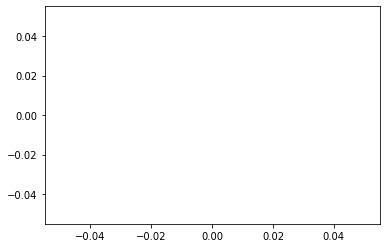

In [45]:
plt.plot(data=miami_data_pivot_roi_zip_guests, table=True)
plt.savefig('newsletter_features/miami_data_pivot_roi_zip_guests.png')

In [37]:
#miami_data_pivot_roi_zip_guests = miami_data_pivot_roi_zip_guests.reset_index()

#get header of data
miami_data_pivot_roi_zip_guests = miami_data_pivot_roi_zip_guests.index.map(str)
data_columns = list(miami_data_pivot_roi_zip_guests[0].keys())
#get values of data and put them in a list
data_values = list(i[j] for j in data_columns for i in miami_data_pivot_roi_zip_guests) # I used comprehension expression
#reshape the list because of plotly ordering type.
data_values = np.reshape(data_values, (-1, len(miami_data_pivot_roi_zip_guests))) 

#figure for plotly
fig = go.Figure(data=[go.Table(
    header=dict(values=data_columns,
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=data_values,
               fill_color='lavender',
               align='left'))
])

#show figure
fig.show()

AttributeError: 'Index' object has no attribute 'index'

In [11]:
towns = combined_data_nc['town'].unique()
towns_for_dash = list_options_for_dash(towns)

,Unnamed: 0.1,Unnamed: 0,index,id,name,price,displayPrice,monthlyPriceFactor,weeklyPriceFactor,avgRating,...,state,state_name,state_id,avg_home_value,occupancy_rate,median_cleaning_fee,median_service_fee,median_total_price,avg_30_yr_mort,median_ROI
232,232,2,2,53231187.0,Modern Apartment in excellent location,161.0,$161,1.00,0.93,4.64,...,Florida,Florida,FL,685872.0,0.894476,110.0,38.0,309.0,3681.91,1.283315
233,233,3,3,52364652.0,"Cozy Modern Home, Coral Gables / Coconut Grove",284.0,$284,0.85,0.93,5.00,...,Florida,Florida,FL,1182474.0,0.096863,230.0,103.0,617.0,6347.78,-0.713628
234,234,6,6,29828422.0,"Water view, Brickell, Huge balcony, Free Parking.",164.0,$164,1.00,0.95,4.85,...,Florida,Florida,FL,425586.0,0.418118,150.0,52.0,366.0,2284.64,1.037386
235,235,12,12,39925347.0,✶ Modern Sky Residence w/ City & Ocean Views✶,299.0,$299,0.80,0.80,4.98,...,Florida,Florida,FL,425586.0,0.635616,120.0,66.0,485.0,2284.64,3.104221
236,236,7,7,49032537.0,Lux Hilton Bentley Beachfront Apt Best Location,355.0,$355,1.00,1.00,4.85,...,Florida,Florida,FL,315148.0,0.460186,200.0,95.0,650.0,1691.78,4.377917
237,237,8,8,49567533.0,South of Fifth •GYM POOL & SPA•BEACHFRONT BUIL...,336.0,$336,1.00,1.00,4.90,...,Florida,Florida,FL,315148.0,0.225365,115.0,90.0,541.0,1691.78,1.192051
238,238,15,15,269204.0,5 STAR HILTON BENTLEY BEACH! SOBE!!,238.0,$238,0.98,1.00,4.61,...,Florida,Florida,FL,315148.0,0.880778,150.0,51.0,439.0,1691.78,5.951821
239,239,18,18,31328359.0,ONLY UNIQUE PEOPLE ALLOWED TO STAY HERE-Sobe Flat,136.0,$136,0.62,1.00,4.83,...,Florida,Florida,FL,1823034.0,0.535395,80.0,30.0,246.0,9786.44,-0.590648
240,240,19,19,51171259.0,South of Fifth Spacious 2 Bedroom With Pool,276.0,$276,0.95,0.98,4.25,...,Florida,Florida,FL,600776.0,0.503579,120.0,51.0,447.0,3225.10,1.122970
241,241,9,9,37218395.0,"Miami, Brickell, Downtown, Stylish Condo",162.0,$162,1.00,1.00,4.77,...,Florida,Florida,FL,425586.0,0.199028,75.0,41.0,278.0,2284.64,-0.263365


In [ ]:
lists_per_city = listing_data.groupby(['town'])['id'].count().reset_index()
lists_per_city.rename(columns = {'id':'num_lists_in_town'}, inplace = True)
median_price_per_city = listing_data.groupby(['town'])['price'].median().reset_index()
median_price_per_city.rename(columns = {'price':'median_price_per_city'}, inplace = True)

# Calculate occupancy rate
occ_rate = occ_data.groupby('id')['available'].apply(lambda row: np.sum(row)/len(row))
listing_occ_rate = listing_data.merge(occ_rate, on = 'id')


# Calculate pricing avgs
cleaning_fee = price_data.groupby(['id'])['cleaning_fee'].median().reset_index()
cleaning_fee.rename(columns = {'cleaning_fee':'median_cleaning_fee'}, inplace = True)
service_fee = price_data.groupby(['id'])['service_fee'].median().reset_index()
service_fee.rename(columns = {'service_fee':'median_service_fee'}, inplace = True)
#total_price = price_data.groupby(['id'])['total_price'].median().reset_index()
#total_price.rename(columns = {'total_price':'median_total_price'}, inplace = True)

listing_occ_rate_fees = listing_occ_rate.merge(cleaning_fee, on='id')
listing_occ_rate_fees = listing_occ_rate_fees.merge(service_fee, on='id')
#listing_occ_rate_fees = listing_occ_rate_fees.merge(total_price, on='id')

median_occ_rate_per_city = listing_occ_rate_fees.groupby(['town'])['available'].median().reset_index()
median_occ_rate_per_city.rename(columns = {'available':'occupancy_rate'}, inplace = True)

median_cleaning_fee_per_city = listing_occ_rate_fees.groupby(['town'])['median_cleaning_fee'].median().reset_index()
median_service_fee_per_city = listing_occ_rate_fees.groupby(['town'])['median_service_fee'].median().reset_index()
#median_total_price_per_city = listing_occ_rate_fees.groupby(['town'])['median_total_price'].median().reset_index()
#fees_and_price = cleaning_fee.merge(service_fee, on = 'id')
#fees_and_price = fees_and_price.merge(total_price, on = 'id')

lists_town_price = lists_per_city.merge(median_price_per_city, left_on = 'town', right_on = 'town')
lists_town_price = lists_town_price.merge(median_cleaning_fee_per_city, left_on = 'town', right_on = 'town')
lists_town_price = lists_town_price.merge(median_service_fee_per_city, left_on = 'town', right_on = 'town')
#lists_town_price = lists_town_price.merge(median_total_price_per_city, left_on = 'town', right_on = 'town')
lists_town_price['median_total_price'] = lists_town_price['median_price_per_city'] + lists_town_price['median_cleaning_fee'] + lists_town_price['median_service_fee']
lists_town_price_occ = lists_town_price.merge(median_occ_rate_per_city, left_on = 'town', right_on = 'town')
lists_town_home_price_occ = lists_town_price_occ.merge(city_home, left_on = 'town', right_on = 'city')

lists_town_home_price_occ_vt = lists_town_home_price_occ[(lists_town_home_price_occ['state_id'] == 'VT')]
lists_town_home_price_occ_nh = lists_town_home_price_occ[(lists_town_home_price_occ['state_id'] == 'NH')]
lists_town_home_price_occ_nc = lists_town_home_price_occ[(lists_town_home_price_occ['state_id'] == 'NC')]
lists_town_home_price_occ_sc = lists_town_home_price_occ[(lists_town_home_price_occ['state_id'] == 'SC')]

lists_town_home_price_occ_all = lists_town_home_price_occ_vt.append(lists_town_home_price_occ_nh)
lists_town_home_price_occ_all = lists_town_home_price_occ_all.append(lists_town_home_price_occ_nc)
lists_town_home_price_occ_all = lists_town_home_price_occ_all.append(lists_town_home_price_occ_sc)

lists_town_home_price_occ_all['avg_30_yr_mort'] = lists_town_home_price_occ_all.apply(lambda row: calculate_mortgage(row['2022-04-30'], 5, 30), axis=1)
lists_town_home_price_occ_all['median_ROI'] = lists_town_home_price_occ_all.apply(lambda row: calculate_roi(row['median_price_per_city'], row['occupancy_rate'], row['avg_30_yr_mort']), axis=1)

In [ ]:
# grouping by town and guests

city_home['city'] = city_home['city'].str.lower()
#print("city home shape: " + str(city_home.shape))
lists_per_city_guest = listing_data.groupby(['town', 'guest_no'])['id'].count().reset_index()
lists_per_city_guest.rename(columns = {'id':'num_lists_in_town'}, inplace = True)
#print("lists_per_city_guest shape: " + str(lists_per_city_guest.shape))
median_price_per_city_guest = listing_data.groupby(['town', 'guest_no'])['price'].median().reset_index()
median_price_per_city_guest.rename(columns = {'price':'median_price_per_city'}, inplace = True)
#print("median_price_per_city_guest shape: " + str(median_price_per_city_guest.shape))


# Calculate occupancy rate
occ_rate = occ_data.groupby('id')['available'].apply(lambda row: np.sum(row)/len(row))
listing_occ_rate = listing_data.merge(occ_rate, on = 'id')
#print("listing_occ_rate shape: " + str(listing_occ_rate.shape))



# Calculate pricing avgs
cleaning_fee = price_data.groupby(['id'])['cleaning_fee'].median().reset_index()
cleaning_fee.rename(columns = {'cleaning_fee':'median_cleaning_fee'}, inplace = True)
service_fee = price_data.groupby(['id'])['service_fee'].median().reset_index()
service_fee.rename(columns = {'service_fee':'median_service_fee'}, inplace = True)
#total_price = price_data.groupby(['id'])['total_price'].median().reset_index()
#total_price.rename(columns = {'total_price':'median_total_price'}, inplace = True)

listing_occ_rate_fees = listing_occ_rate.merge(cleaning_fee, on='id')
#print("listing_occ_rate_fees shape: " + str(listing_occ_rate_fees.shape))
listing_occ_rate_fees = listing_occ_rate_fees.merge(service_fee, on='id')
#print("listing_occ_rate_fees shape: " + str(listing_occ_rate_fees.shape))

#listing_occ_rate_fees = listing_occ_rate_fees.merge(total_price, on='id')

median_occ_rate_per_city_guest = listing_occ_rate_fees.groupby(['town', 'guest_no'])['available'].median().reset_index()
median_occ_rate_per_city_guest.rename(columns = {'available':'occupancy_rate'}, inplace = True)
#print("median_occ_rate_per_city_guest shape: " + str(median_occ_rate_per_city_guest.shape))


median_cleaning_fee_per_city_guest = listing_occ_rate_fees.groupby(['town', 'guest_no'])['median_cleaning_fee'].median().reset_index()
#print("median_occ_rate_per_city_guest shape: " + str(median_occ_rate_per_city_guest.shape))

median_service_fee_per_city_guest = listing_occ_rate_fees.groupby(['town', 'guest_no'])['median_service_fee'].median().reset_index()
#print("median_service_fee_per_city_guest shape: " + str(median_service_fee_per_city_guest.shape))


lists_town_price_guest = lists_per_city_guest.merge(median_price_per_city_guest, on = ['town', 'guest_no'])
#print("lists_town_price_guest shape: " + str(lists_town_price_guest.shape))

lists_town_price_guest = lists_town_price_guest.merge(median_cleaning_fee_per_city_guest, on = ['town', 'guest_no'])
#print("lists_town_price_guest shape: " + str(lists_town_price_guest.shape))

lists_town_price_guest = lists_town_price_guest.merge(median_service_fee_per_city_guest, on = ['town', 'guest_no'])
#print("lists_town_price_guest shape: " + str(lists_town_price_guest.shape))

#lists_town_price = lists_town_price.merge(median_total_price_per_city, left_on = 'town', right_on = 'town')
lists_town_price_guest['median_total_price'] = lists_town_price_guest['median_price_per_city'] + lists_town_price_guest['median_cleaning_fee'] + lists_town_price_guest['median_service_fee']
#print("lists_town_price_guest shape: " + str(lists_town_price_guest.shape))

lists_town_price_occ_guest = lists_town_price_guest.merge(median_occ_rate_per_city_guest, on = ['town', 'guest_no'])
#print("lists_town_price_guest shape: " + str(lists_town_price_guest.shape))

city_home_needed_cols = city_home[['city','state_id','population','2022-04-30']]
#print("city_home_needed_cols shape: " + str(city_home_needed_cols.shape))

lists_town_home_price_occ_guest = lists_town_price_occ_guest.merge(city_home_needed_cols, how='inner', left_on = 'town', right_on = 'city')
#print("lists_town_home_price_occ_guest shape: " + str(lists_town_home_price_occ_guest.shape))

# Calculate 30 year mortgage for town
lists_town_home_price_occ_guest['avg_30_yr_mort'] = lists_town_home_price_occ_guest.apply(lambda row: calculate_mortgage(row['2022-04-30'], 5, 30), axis=1)
# Calculate median ROI for town
lists_town_home_price_occ_guest['median_ROI'] = lists_town_home_price_occ_guest.apply(lambda row: calculate_roi(row['median_price_per_city'], row['occupancy_rate'], row['avg_30_yr_mort']), axis=1)


wb_data = lists_town_home_price_occ_guest[lists_town_home_price_occ_guest['town'] == 'wrightsville beach']
#print("wb_data shape: " + str(wb_data.shape))

# Create pivot table for nc towns
lists_town_home_price_occ_guest_nc = lists_town_home_price_occ_guest[(lists_town_home_price_occ_guest['state_id'] == 'NC')]
num_lists_pivot = lists_town_home_price_occ_guest_nc.pivot(index='town', columns='guest_no', values='num_lists_in_town')

In [268]:
import dash
import dash_html_components as html
import plotly.graph_objects as go
import dash_core_components as dcc
import plotly.express as px
from dash.dependencies import Input, Output


app = dash.Dash()

df = px.data.stocks()

towns = combined_data_nc['town'].unique()
options_list, value_for_dropdown = list_options_for_dash(towns)


app.layout = html.Div(id = 'parent', children = [
    html.H1(id = 'H1', children = 'Styling using html components', style = {'textAlign':'center',\
                                            'marginTop':40,'marginBottom':40}),

        dcc.Dropdown( id = 'dropdown',
        options = options_list,
        value = value_for_dropdown),
        dcc.Graph(id = 'bar_plot')
    ])
    
    
@app.callback(Output(component_id='bar_plot', component_property= 'figure'),
              [Input(component_id='dropdown', component_property= 'value')])
def graph_update(dropdown_value):
    print(dropdown_value)
    fig = go.Figure([go.Bar(x = combined_data_nc['guest_no'], y = df['{}'.format(dropdown_value)],\
                     line = dict(color = 'firebrick', width = 4))
                     ])
    
    fig.update_layout(title = 'Stock prices over time',
                      xaxis_title = 'Dates',
                      yaxis_title = 'Prices'
                      )
    return fig  



if __name__ == '__main__': 
    app.run_server()

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050 (Press CTRL+C to quit)
127.0.0.1 - - [24/May/2022 01:47:53] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [24/May/2022 01:47:54] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [24/May/2022 01:47:54] "GET /_favicon.ico?v=2.4.1 HTTP/1.1" 200 -
127.0.0.1 - - [24/May/2022 01:47:54] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [24/May/2022 01:47:54] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 304 -
127.0.0.1 - - [24/May/2022 01:47:54] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [24/May/2022 01:47:54] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -


bald head island
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "c:\Users\mattg\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexes\base.py", line 3621, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 163, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 5206, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'bald head island'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\mattg\AppData\Local\Programs\Python\Python310\lib\site-packages\flask\app.py", line 2077, in wsgi_app
    response = self.full_dispatch_request()
  File "c:\Users\mattg\AppData\

127.0.0.1 - - [24/May/2022 01:47:54] "POST /_dash-update-component HTTP/1.1" 500 -


carolina beach
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "c:\Users\mattg\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexes\base.py", line 3621, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas\_libs\index.pyx", line 136, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 163, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 5206, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'carolina beach'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\mattg\AppData\Local\Programs\Python\Python310\lib\site-packages\flask\app.py", line 2077, in wsgi_app
    response = self.full_dispatch_request()
  File "c:\Users\mattg\AppData\Loca

127.0.0.1 - - [24/May/2022 01:47:58] "POST /_dash-update-component HTTP/1.1" 500 -


: 

: 

In [180]:
def med_price_occ_by_guests(df, location: str):
    df_guests = df.groupby(['guest_no'])['median_total_price'].median().reset_index()
    df_occ = df.groupby(['guest_no'])['occupancy_rate'].median().reset_index()

    med_price_occ_by_guests = go.Figure(data=[
        go.Bar(name='Total Price', x=df_guests['guest_no'], y=df_guests['median_total_price'], yaxis='y', offsetgroup=1),
        go.Bar(name='Occupancy Rate', x=df_occ['guest_no'], y=df_occ['occupancy_rate'], yaxis='y2', offsetgroup=2),
    ],
        layout={
            'xaxis': {'title': '# of Guests'},
            'yaxis': {'title': 'Total Price'},
            'yaxis2': {'title': 'Occupancy Rate', 'overlaying': 'y', 'side': 'right'}
        }
    )

    # Change the bar mode
    med_price_occ_by_guests.update_layout(title_text='Median Price and Occupancy by # of Guests in '+location, barmode='group')
    filename = "newsletter_features/"+location+"_median_price_and_occ_by_guestno.png"
    med_price_occ_by_guests.write_image(filename, engine='kaleido')
    #miami_fig.show()

def avg_30yrmort_by_guests(df, location: str):
    df_guests_mort = df.groupby(['guest_no'])['avg_30_yr_mort'].median().reset_index()

    avg_mort_by_guests_fig = go.Figure(data=[
        go.Bar(name='Total Price', x=df_guests_mort['guest_no'], y=df_guests_mort['avg_30_yr_mort'])
    ],
        layout={
            'xaxis': {'title': '# of Guests'},
            'yaxis': {'title': 'Monthly Mortgage Cost ($)'},
        }
    )

    # Change the bar mode
    avg_mort_by_guests_fig.update_layout(title_text='Avg 30-Year Mortgage by # of Guests in '+location)
    filename = "newsletter_features/"+location+"_monthly_mortgage_by_guestno.png"
    avg_mort_by_guests_fig.write_image(filename, engine='kaleido')
    #miami_fig.show()


def avg_roi_fig_generator(df, location: str, groupbycol='Zipcode', filename_end="_zips_roi_fig.png"):
    #df['zipcode'] = df.apply(lambda row: set_zipcode(row['lat'], row['lng']), axis=1)
    zips_roi_df = df.groupby(groupbycol)[['median_ROI']].mean().reset_index()

    zips_roi_fig = go.Figure(data=[
        go.Bar(name='Display Price', x=zips_roi_df[groupbycol], y=zips_roi_df['median_ROI']),
        ],
        
        layout={
            'xaxis': {'title': groupbycol},
            'yaxis': {'title': 'ROI (1 = 100%)'},
        }
    )

    # Change the bar mode
    zips_roi_fig.update_layout(title_text='Average ROI in '+location+' by '+groupbycol, barmode='stack')
    filename = "newsletter_features/"+location+filename_end
    zips_roi_fig.write_image(filename, engine='kaleido')
    #zips_roi_fig.show()


def pricing_fig_generator(df, location: str, groupbycol='Zipcode', filename_end="_zips_cleaning_fig.png"):
    #df['zipcode'] = df.apply(lambda row: set_zipcode(row['lat'], row['lng']), axis=1)

    zips_cleaning_df = df.groupby([groupbycol])[['price','median_cleaning_fee','median_service_fee']].median().reset_index()

    zips_cleaning_fig = go.Figure(data=[
        go.Bar(name='Display Price', x=zips_cleaning_df[groupbycol], y=zips_cleaning_df['price']),
        go.Bar(name='Cleaning Fee', x=zips_cleaning_df[groupbycol], y=zips_cleaning_df['median_cleaning_fee']),
        go.Bar(name='Service Fee', x=zips_cleaning_df[groupbycol], y=zips_cleaning_df['median_service_fee']),
    ],
        layout={
            'xaxis': {'title': groupbycol},
            'yaxis': {'title': 'Total Price ($)'},
        }
    )

    # Change the bar mode
    zips_cleaning_fig.update_layout(title_text='Median Pricing in '+location+' by '+groupbycol, barmode='stack')
    filename = "newsletter_features/"+location+filename_end
    zips_cleaning_fig.write_image(filename, engine='kaleido')
    #miami_zips_cleaning_fig.show()

def roi_bubble_plot(df):
    import plotly.express as px
    #df['City'] = df.apply(lambda row: set_city(row['lat'], row['lng'], axis=1))
    df_group = df.groupby(['City','state_id','Zipcode','guest_no'])['avg_30_yr_mort','median_ROI'].mean().reset_index()

    roi_bubble_fig = px.scatter(df_group, x="guest_no", y="median_ROI",
                size="avg_30_yr_mort", color="state_id",
                    hover_name="Zipcode")
    
    roi_bubble_fig.update_layout(title_text='ROI vs Guest Number, sized by the Avg Monthly Mortgage', xaxis=dict(title='Guest Number for Listing'), yaxis=dict(title='Average ROI (1 = 100%)'))
    roi_bubble_fig.show()


In [130]:
combined_data = pd.read_csv('post_mort_and_roi_calcs.csv')
combined_data_vt = combined_data[(combined_data['state_id'] == 'VT')]
combined_data_nh = combined_data[(combined_data['state_id'] == 'NH')]
combined_data_nc = combined_data[(combined_data['state_id'] == 'NC')]
combined_data_sc = combined_data[(combined_data['state_id'] == 'SC')]
combined_data_fl = combined_data[(combined_data['state_id'] == 'FL')]
combined_data_me = combined_data[(combined_data['state_id'] == 'ME')]

In [144]:
df = combined_data_me
loc = 'Maine'

med_price_occ_by_guests(df, location=loc)
df['Zipcode'] = df.apply(lambda row: set_zipcode(row['lat'], row['lng']), axis=1)
avg_roi_fig_generator(df, location=loc)
pricing_fig_generator(df, location=loc)
#df['city'] = df.apply(lambda row: set_city(row['lat'], row['lng']), axis=1)
df = df.rename(columns={'town': 'City'})
avg_roi_fig_generator(df, location=loc,groupbycol='City',filename_end="_cities_roi_fig.png")
pricing_fig_generator(df, location=loc,groupbycol='City',filename_end="_cities_cleaning_fig.png")


In [149]:
avg_30yrmort_by_guests(combined_data_vt, location='Vermont')
avg_30yrmort_by_guests(combined_data_nh, location='New_Hampshire')
avg_30yrmort_by_guests(combined_data_nc, location='North_Carolina')
avg_30yrmort_by_guests(combined_data_sc, location='South_Carolina')
avg_30yrmort_by_guests(combined_data_fl, location='Miami')
avg_30yrmort_by_guests(combined_data_me, location='Maine')

In [161]:
#combined_data.columns
combined_data['City'] = combined_data.apply(lambda row: set_city(row['lat'], row['lng']), axis=1)
combined_data['Zipcode'] = combined_data.apply(lambda row: set_zipcode(row['lat'], row['lng']), axis=1)
combined_data = combined_data[combined_data['avg_30_yr_mort'].notna()]


In [181]:
roi_bubble_plot(combined_data)